In [1]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from notebooks.core import constants
from notebooks.core import model_utils

In [2]:
df = pd.read_json('../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')
df = df.iloc[:10000]

In [3]:
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
9995,0,Posłuchajcie America: A Huffpost Road Trip
9996,0,"Premiera wideo z ""White Christmas"" Ginger Minj"
9997,0,"Przewodnik pragmatyka, aby wyjść silniejszym p..."
9998,1,Misje „wielkiej kradzieży auto vs” skupiają si...


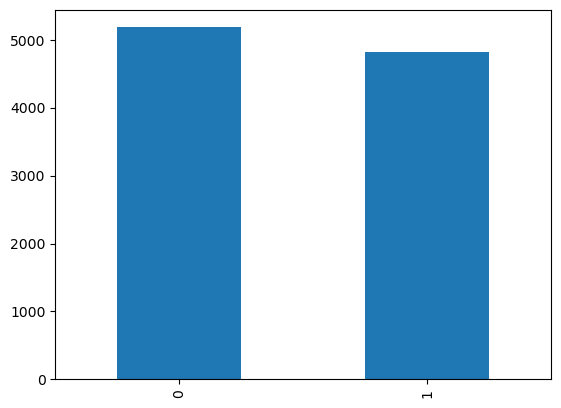

In [4]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [5]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['is_sarcastic', 'headline_pl'],
    num_rows: 10000
})

In [6]:
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

In [7]:
def tokenize_function(example):
    return tokenizer(example["headline_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5)

In [9]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["is_sarcastic"]
batch_size = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [10]:
# Model parameters
training_number = 1
model_name = "sarcasm_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [11]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [12]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [13]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
1000/1000 [==============================] - 77s 66ms/step - loss: 0.4715 - accuracy: 0.7729 - val_loss: 0.4116 - val_accuracy: 0.8010

Epoch 00001: saving model to ../../training_checkpoints\sarcasm_pl_bert\training_1\cp-0001.ckpt
Epoch 2/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.2354 - accuracy: 0.9075 - val_loss: 0.5155 - val_accuracy: 0.8020

Epoch 00002: saving model to ../../training_checkpoints\sarcasm_pl_bert\training_1\cp-0002.ckpt
Epoch 3/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0963 - accuracy: 0.9650 - val_loss: 0.5553 - val_accuracy: 0.8070

Epoch 00003: saving model to ../../training_checkpoints\sarcasm_pl_bert\training_1\cp-0003.ckpt
Epoch 4/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0471 - accuracy: 0.9835 - val_loss: 0.7159 - val_accuracy: 0.8110

Epoch 00004: saving model to ../../training_checkpoints\sarcasm_pl_bert\training_1\cp-0004.ckpt


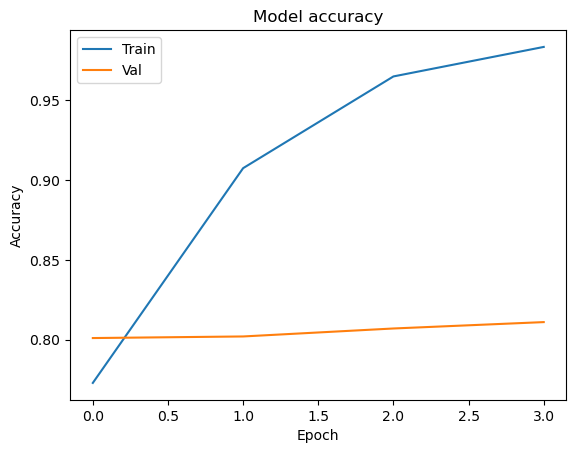

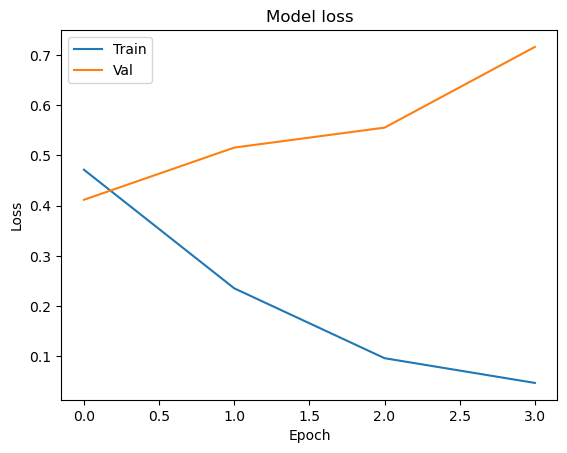

In [16]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [17]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [18]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_bert_1\1\assets


INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_bert_1\1\assets


In [19]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

125/125 [==============================] - 3s 25ms/step - loss: 0.3741 - accuracy: 0.8290


[0.3740564286708832, 0.8289999961853027]

In [20]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

In [21]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['is_sarcastic'],
    class_preds=class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.7697594501718213
Recall score:  0.9237113402061856
F1 score:  0.8397375820056233


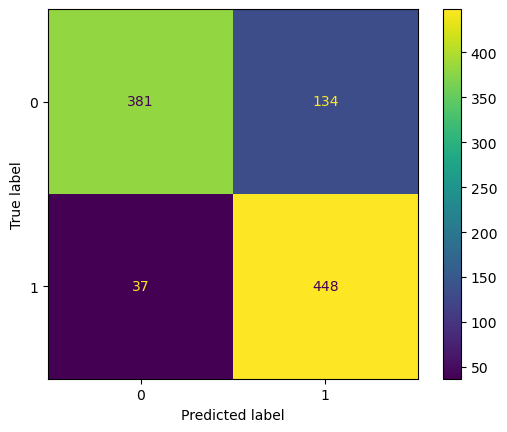

In [22]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['is_sarcastic'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [23]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['headline_pl'],
                                              class_actual=raw_dataset['is_sarcastic'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Reprezentantka rządu USA wyjaśnia, dlaczego Kongresowi brakuje równości płci i rasy
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: Nieprzyjemna pogoda uniemożliwia kłamcy dotarcie do pracy
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: matka jest bardzo blisko użycia słowa "streaming" poprawnie
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 6
            - TEXT: 5 sposobów na złożenie podatków przy mniejszym stresie
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 9
            - TEXT: Wielu rodziców zna ten scenariusz.
            - PREDICTED VALUE: 1
       